# Package Functionality

We've done some ad-hoc coding in notebooks, and now formalized the approach in the `air-quality` package. Here we demo the features (also useful for testing usability), and pickle the objects we need to execute our pipeline on a server.

In [1]:
import pandas as pd
import numpy as np 
import sqlite3
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
import pickle

import air_quality as aq

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
!ls ../data/interim/

aq_amsterdam.csv                   regular_daily_with_derivatives.csv
openaq.db                          regular_hourly.csv
regular_daily.csv


The data is now in a database. The raw data was too big to be practical (Hive, please), but I've pre-filtered for `Amsterdam` and put both the raw and the interim data in the db. There is also a script, `scripts/get_data`, for getting the most recent updates from OpenAQ and loading them. 

In [4]:
DB_FILE = '../data/db/aq.db'
MODEL_DIR = '../models/v0'

In [5]:
conn = sqlite3.connect(DB_FILE)

In [6]:
df_raw = pd.read_sql_query("""SELECT * FROM amsterdam_raw;""", conn)
conn.close()
df_raw.tail()

,location,city,country,utc,local,parameter,value,unit,latitude,longitude,attribution
776207,Amsterdam-Hoogtij,Amsterdam,NL,2018-10-06T21:00:00.000Z,2018-10-06T23:00:00+02:00,pm25,0.5,Âµg/mÂ³,52.4280,4.77348,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
776208,Amsterdam-Einsteinweg,Amsterdam,NL,2018-10-06T21:00:00.000Z,2018-10-06T23:00:00+02:00,pm10,11.8,Âµg/mÂ³,52.3813,4.84523,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
776209,Amsterdam-Van Diemenstraat,Amsterdam,NL,2018-10-06T21:00:00.000Z,2018-10-06T23:00:00+02:00,pm10,2.2,Âµg/mÂ³,52.3900,4.88781,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
776210,Amsterdam-Stadhouderskade,Amsterdam,NL,2018-10-06T21:00:00.000Z,2018-10-06T23:00:00+02:00,pm25,5.1,Âµg/mÂ³,52.3580,4.89970,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."
776211,Amsterdam-Stadhouderskade,Amsterdam,NL,2018-10-06T21:00:00.000Z,2018-10-06T23:00:00+02:00,pm10,5.4,Âµg/mÂ³,52.3580,4.89970,"[{""name"":""RIVM"",""url"":""http://www.lml.rivm.nl/..."


The raw data can be easily transformed into the intermediate form (this is also done in the `get_data` script).

In [7]:
df = aq.data_processing.raw_to_interim(df_raw)

In [8]:
df.tail()

,pm10_Einsteinweg,pm10_Hoogtij,pm10_Spaarnwoude,pm10_Stadhouderskade,pm10_Van Diemenstraat,pm10_Vondelpark,pm10_Westerpark,pm25_Einsteinweg,pm25_Hoogtij,pm25_Spaarnwoude,...,pm10_Van Diemenstraat_der,pm10_Vondelpark_der,pm10_Westerpark_der,pm25_Einsteinweg_der,pm25_Hoogtij_der,pm25_Spaarnwoude_der,pm25_Stadhouderskade_der,pm25_Van Diemenstraat_der,pm25_Vondelpark_der,pm25_Westerpark_der
local,,,,,,,,,,,,,,,,,,,,,
2018-10-02,16.907143,13.192857,14.500000,20.492857,23.821429,14.000000,14.835714,3.971429,5.957143,5.264286,...,33.930835,17.568951,15.456745,9.023126,-2.820128,3.038544,5.979443,6.886510,1.667666,6.744540
2018-10-03,24.394444,19.066667,21.661111,29.461111,30.850000,20.605556,23.133333,5.027778,9.166667,6.983333,...,-13.191102,-9.279025,-6.519280,-1.779343,1.193644,-0.424258,-1.363983,0.704237,-4.875953,-2.196610
2018-10-04,19.085714,14.614286,19.457143,23.957143,23.300000,22.528571,21.271429,6.785714,11.657143,7.457143,...,-1.890511,13.246715,8.550365,5.210219,0.598540,10.797080,8.887591,6.550365,14.970803,8.871533
2018-10-05,42.750000,43.700000,24.840000,65.020000,48.140000,29.080000,39.310000,22.210000,24.270000,17.150000,...,49.854082,22.769388,56.926531,11.870408,2.552041,-8.484694,29.333673,3.228571,9.001020,16.707143
2018-10-06,41.381818,41.263636,23.554545,39.409091,42.027273,32.054545,31.972727,23.709091,24.145455,17.527273,...,18.465916,7.289253,14.383214,-2.836847,5.464893,9.012897,-2.192835,37.532856,-1.270420,2.155988


We can select a target and process the interim data into a training set, fitting the reuired transformers along the way:

In [9]:
target = 'pm10_Vondelpark'
X, y, X_scaler, y_scaler, pca = aq.data_processing.interim_to_training_set(
    df, target, pca_components=18, lookback=2,
)

**TODO:** This is quite a specific interface (returning the exact objects needed for this pipeline). It would be better to define our own estimator that adheres to the sklearn API, to be able to upgrade our pipeline more easily.

In [10]:
X_train = X.loc['2016']
X_test = X.loc['2017':]

y_train = y.loc['2016']
y_test = y.loc['2017':]


In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

/Users/johnpaton/personal/air-quality/venv/air-quality/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
y_pred = model.predict(X_test)
y_pred = pd.Series(y_pred, index=X_test.index)

MSE: 0.5668210908075155


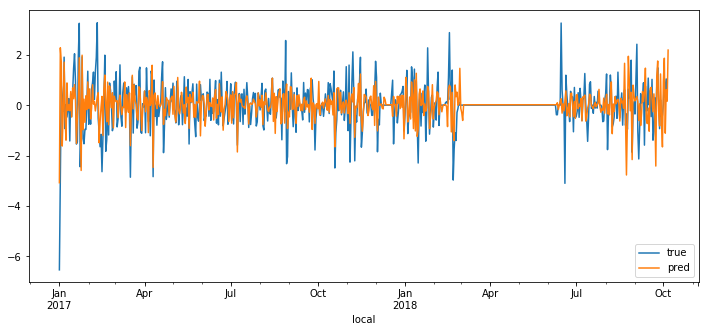

In [13]:
plt.figure(figsize=(12,5))
y_test.plot(label='true')
y_pred.plot(label='pred')
print('MSE:', mean_squared_error(y_test[:-1], y_pred[:-1]))
plt.legend()

In [14]:
values = df[target].loc['2017':]
values_pred = aq.modelling.predict_values(X_test, values, model, y_scaler)

MSE: 22.441369023475882


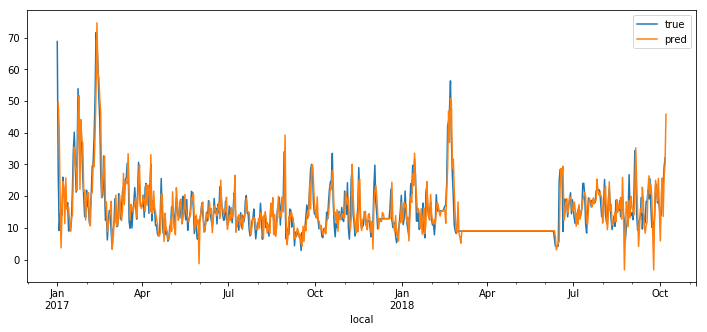

In [15]:
plt.figure(figsize=(12,5))
values.plot(label='true')
values_pred.plot(label='pred')
print('MSE:', mean_squared_error(values.iloc[1:], values_pred.iloc[:-1]))
plt.legend();

Zoom in on 2018 to check how we're doing after the big data shift.

27.190894757308975


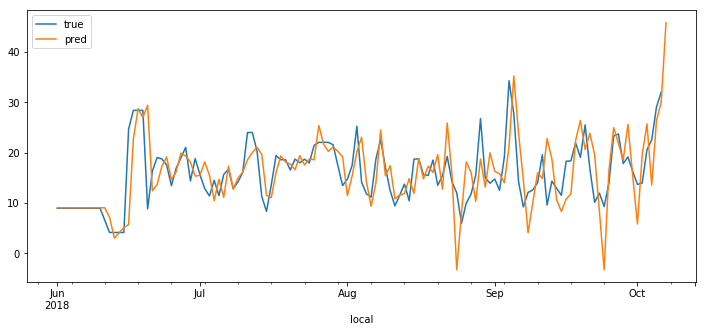

In [16]:
plt.figure(figsize=(12,5))
values['2018-06':].plot(label='true')
values_pred['2018-06':].plot(label='pred')
print(mean_squared_error(values.iloc[1:]['2018-06':], values_pred.iloc[:-1]['2018-06':]))
plt.legend();

Pretty okay, performance is similar to 2017. These big changes should be monitored in prodction with a data quality testing service like `marbles`.

In [17]:
X.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
local,,,,,,,,,,,,,,,,,,
2018-10-02,-4.339136,5.091779,1.161271,-0.079918,-1.369797,0.102715,0.834577,-0.867508,0.533079,-1.466075,2.016816,-1.563114,2.438986,-0.487190,0.622383,0.922642,1.382089,-0.657252
2018-10-03,-3.756935,-5.274252,-2.590946,-0.229630,4.565532,2.755007,-1.232783,-0.332183,0.190648,-0.252840,0.122011,0.223902,-0.847035,-0.876555,-1.044494,-0.914664,-1.105851,0.628850
2018-10-04,5.494775,-1.435285,-2.766388,-0.841968,-2.852923,-3.065793,-2.566756,-0.245129,0.466983,0.505438,-1.286094,0.094384,-0.090448,-0.354549,0.734189,0.265126,-0.510696,-0.839119
2018-10-05,-4.477375,7.062953,-3.680860,-8.891433,-3.811120,-2.965482,6.595681,2.805143,0.397371,-0.090100,-0.362118,-2.717225,2.897301,-1.343688,-3.415730,-1.125064,1.134181,2.222526
2018-10-06,-4.343108,-11.856924,2.581722,-0.910592,-1.531204,9.467721,-4.474371,-4.648516,-4.353572,-3.293834,4.017542,1.994528,-2.362599,4.284288,6.180009,2.415928,-0.091930,0.431301


Confirm: We predict one day into the future.

In [31]:
values_pred.iloc[-3:]

local
2018-10-05    26.360541
2018-10-06    30.076887
2018-10-07    45.813902
Freq: D, Name: pm10_Vondelpark, dtype: float64

Save the objects we need and then it's off to the server!

In [21]:
with open(MODEL_DIR+'/X_scaler.pkl', 'wb') as h:
    pickle.dump(X_scaler, h)

with open(MODEL_DIR+'/y_scaler.pkl', 'wb') as h:
    pickle.dump(y_scaler, h)
    
with open(MODEL_DIR+'/pca.pkl', 'wb') as h:
    pickle.dump(pca, h)
    
with open(MODEL_DIR+'/model.pkl', 'wb') as h:
    pickle.dump(model, h)